In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PricingEnvironment:
    def __init__(self):
        pass

    def round(self, p_t, v_t):
        d_t = 1 if v_t >= p_t else 0
        r_t = p_t*d_t
        return d_t, r_t

In [6]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

    def get_val(self):
        return np.random.uniform(0,1)    

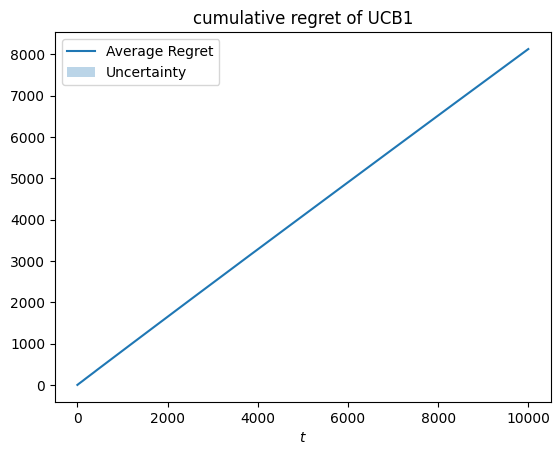

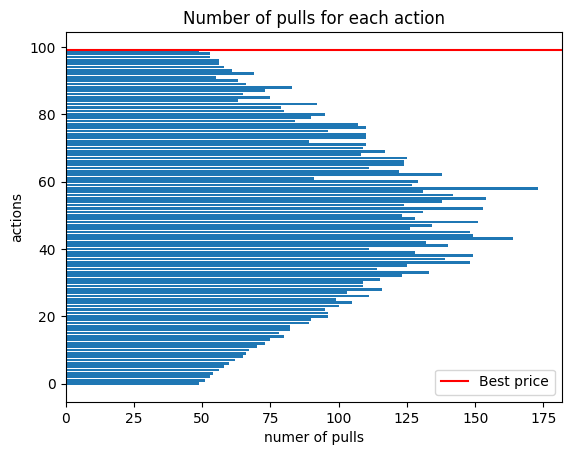

In [7]:
T = 10000 # try T=100, why this behavior?
K = 100

prices = np.linspace(0,1,K) # 100 actions!

n_customers = 1 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: price*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment()
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        v_t = ucb_agent.get_val()
        d_t, r_t = env.round(p_t, v_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();